# Improvement through data driven Marginals, Section 5.4.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from MOT_2dim2assets import *
from matplotlib import rc
from matplotlib import style
from scipy.interpolate import interp1d
from scipy.stats import pearsonr, norm
from scipy import stats
import random
style.use('ggplot')

First, we import the csv files containing the data (Company1 = Apple, Company2 = Microsoft)

In [2]:
company_1_t1_call = pd.read_csv('csv/company_1_t1_call.csv')
company_1_t2_call = pd.read_csv('csv/company_1_t2_call.csv')
company_2_t1_call = pd.read_csv('csv/company_2_t1_call.csv')
company_2_t2_call = pd.read_csv('csv/company_2_t2_call.csv')
company_1_t1_put = pd.read_csv('csv/company_1_t1_put.csv')
company_1_t2_put = pd.read_csv('csv/company_1_t2_put.csv')
company_2_t1_put = pd.read_csv('csv/company_2_t1_put.csv')
company_2_t2_put = pd.read_csv('csv/company_2_t2_put.csv')

Next, we want to derive the corresponding marginals.
According to Breeden-Litzenberger, and by applying finite differences, we have
$$
prob(K) \approx \frac{C(K_{i+1},t)-2C(K_{i},t)+C(K_{i-1},t)}{(K_{i+1}-K_{i})(K_{i}-K_{i-1})}= \frac{P(K_{i+1},t)-2P(K_{i},t)+P(K_{i-1},t)}{(K_{i+1}-K_{i})(K_{i}-K_{i-1})}
$$
We leave out the first and last strike.

We then normalize the sum of probabilities

In [3]:
def prices_to_density(strikes_call,prices_call,strikes_put,prices_put,finite_differences = True):
    probs = []
    strikes = []
    # First Stike
    probs.append(0)
    strikes.append(strikes_put[0])
    if finite_differences:
        #Loop over Put Options 
        for i in range(1,len(strikes_put)-1):
            probs.append((prices_put[i+1]-2*prices_put[i]+prices_put[i-1])/((strikes_put[i+1]-strikes_put[i])*(strikes_put[i]-strikes_put[i-1])))
            strikes.append(strikes_put[i])
        #Loop over Call Options 
        for i in range(1,len(strikes_call)-1):
            probs.append((prices_call[i+1]-2*prices_call[i]+prices_call[i-1])/((strikes_call[i+1]-strikes_call[i])*(strikes_call[i]-strikes_call[i-1])))
            strikes.append(strikes_call[i])
    else:
        #Loop over Put Options 
        for i in range(1,len(strikes_put)-1):
            probs.append((prices_put[i+1]-prices_put[i])/(strikes_put[i+1]-strikes_put[i])-(prices_put[i]-prices_put[i-1])/(strikes_put[i]-strikes_put[i-1]))
            strikes.append(strikes_put[i])
        #Loop over Call Options 
        for i in range(1,len(strikes_call)-1):
            probs.append((prices_call[i+1]-prices_call[i])/(strikes_call[i+1]-strikes_call[i])-(prices_call[i]-prices_call[i-1])/(strikes_call[i]-strikes_call[i-1]))
            strikes.append(strikes_call[i])
    # Last Strike
    probs.append(0)
    strikes.append(strikes_call[-1])
    #normalize
    sum_p = sum(probs)
    probs = [p/sum_p for p in probs]
    return strikes, probs

Clean the call option prices for non-decreasing prices

In [4]:
def clean_call_prices(list_of_strikes,list_of_prices):
    while(any(np.diff(np.array(list_of_prices))>0)):
        violation_index = 1000000000
        for i in range(1,len(list_of_strikes)):
            if list_of_prices[i]>list_of_prices[i-1]:
                violation_index = i
                break
        list_of_strikes = [list_of_strikes[i] for i in range(len(list_of_strikes)) if i != violation_index]
        list_of_prices  = [list_of_prices [i] for i in range(len(list_of_prices )) if i != violation_index]
    return list_of_strikes, list_of_prices

In [5]:
company_1_t1_call_STRIKE_PRC, company_1_t1_call_MID = clean_call_prices(list(company_1_t1_call.STRIKE_PRC),
                                                                        list(company_1_t1_call.MID))
company_2_t1_call_STRIKE_PRC, company_2_t1_call_MID = clean_call_prices(list(company_2_t1_call.STRIKE_PRC),
                                                                        list(company_2_t1_call.MID))
company_1_t2_call_STRIKE_PRC, company_1_t2_call_MID = clean_call_prices(list(company_1_t2_call.STRIKE_PRC),
                                                                        list(company_1_t2_call.MID))
company_2_t2_call_STRIKE_PRC, company_2_t2_call_MID = clean_call_prices(list(company_2_t2_call.STRIKE_PRC),
                                                                        list(company_2_t2_call.MID))

We proceed similarly for put options

In [6]:
def clean_put_prices(list_of_strikes,list_of_prices):
    while(any(np.diff(np.array(list_of_prices))<0)):
        violation_index = 1000000000
        for i in range(1,len(list_of_strikes)):
            if list_of_prices[i]<list_of_prices[i-1]:
                violation_index = i
                break
        list_of_strikes = [list_of_strikes[i] for i in range(len(list_of_strikes)) if i != violation_index]
        list_of_prices  = [list_of_prices [i] for i in range(len(list_of_prices )) if i != violation_index]
    return list_of_strikes, list_of_prices

In [7]:
company_1_t1_put_STRIKE_PRC, company_1_t1_put_MID = clean_put_prices(list(company_1_t1_put.STRIKE_PRC),
                                                                        list(company_1_t1_put.MID))
company_2_t1_put_STRIKE_PRC, company_2_t1_put_MID = clean_put_prices(list(company_2_t1_put.STRIKE_PRC),
                                                                        list(company_2_t1_put.MID))
company_1_t2_put_STRIKE_PRC, company_1_t2_put_MID = clean_put_prices(list(company_1_t2_put.STRIKE_PRC),
                                                                        list(company_1_t2_put.MID))
company_2_t2_put_STRIKE_PRC, company_2_t2_put_MID = clean_put_prices(list(company_2_t2_put.STRIKE_PRC),
                                                                        list(company_2_t2_put.MID))

We continue cleaning by checking the convexity conditions, i.e. we check that
$$ \frac{C(K_{i+1},t)-C(K_{i},t)}{K_{i+1}-K_{i}}
$$
as well as
$$ \frac{P(K_{i+1},t)-P(K_{i},t)}{K_{i+1}-K_{i}}
$$
are increasing functions in $K_i$.
We leave out the first and last strike.

We then normalize the sum of probabilities

In [8]:
def clean_prices_2(list_of_strikes,list_of_prices,finite_differences = True):
    if finite_differences:
        slope =  [(list_of_prices[i+1]-2*list_of_prices[i]+list_of_prices[i-1])/((list_of_strikes[i+1]-list_of_strikes[i])*(list_of_strikes[i]-list_of_strikes[i-1])) for i in range(1,len(list_of_strikes)-1)]
    else:
        slope = [(list_of_prices[i+1]-list_of_prices[i])/(list_of_strikes[i+1]-list_of_strikes[i])-(list_of_prices[i]-list_of_prices[i-1])/(list_of_strikes[i]-list_of_strikes[i-1]) for i in range(1,len(list_of_strikes)-1)]      
    while(any((np.array(slope))<0)):
        violation_index = 1000000000
        for i in range(len(list_of_strikes)-2):
            if slope[i]<0:
                violation_index = i+2
                break
        list_of_strikes = [list_of_strikes[i] for i in range(len(list_of_strikes)) if i != violation_index]
        list_of_prices  = [list_of_prices [i] for i in range(len(list_of_prices )) if i != violation_index]
        if finite_differences:
            slope =  [(list_of_prices[i+1]-2*list_of_prices[i]+list_of_prices[i-1])/((list_of_strikes[i+1]-list_of_strikes[i])*(list_of_strikes[i]-list_of_strikes[i-1])) for i in range(1,len(list_of_strikes)-1)]
        else:
            slope = [(list_of_prices[i+1]-list_of_prices[i])/(list_of_strikes[i+1]-list_of_strikes[i])-(list_of_prices[i]-list_of_prices[i-1])/(list_of_strikes[i]-list_of_strikes[i-1]) for i in range(1,len(list_of_strikes)-1)]      

    return list_of_strikes, list_of_prices

In [9]:
 company_1_t1_call_STRIKE_PRC, company_1_t1_call_MID = clean_prices_2(company_1_t1_call_STRIKE_PRC,
                                                                         company_1_t1_call_MID)
 company_2_t1_call_STRIKE_PRC, company_2_t1_call_MID = clean_prices_2(company_2_t1_call_STRIKE_PRC,
                                                                         company_2_t1_call_MID)
 company_1_t2_call_STRIKE_PRC, company_1_t2_call_MID = clean_prices_2(company_1_t2_call_STRIKE_PRC,
                                                                         company_1_t2_call_MID)
 company_2_t2_call_STRIKE_PRC, company_2_t2_call_MID = clean_prices_2(company_2_t2_call_STRIKE_PRC,
                                                                         company_2_t2_call_MID)
 company_1_t1_put_STRIKE_PRC, company_1_t1_put_MID = clean_prices_2(company_1_t1_put_STRIKE_PRC,
                                                                         company_1_t1_put_MID)
 company_2_t1_put_STRIKE_PRC, company_2_t1_put_MID = clean_prices_2(company_2_t1_put_STRIKE_PRC,
                                                                         company_2_t1_put_MID)
 company_1_t2_put_STRIKE_PRC, company_1_t2_put_MID = clean_prices_2(company_1_t2_put_STRIKE_PRC,
                                                                         company_1_t2_put_MID)
 company_2_t2_put_STRIKE_PRC, company_2_t2_put_MID = clean_prices_2(company_2_t2_put_STRIKE_PRC,
                                                                         company_2_t2_put_MID)

Convert the prices to probabilities

In [10]:
v11, p11 = prices_to_density(company_1_t1_call_STRIKE_PRC,company_1_t1_call_MID,
                             company_1_t1_put_STRIKE_PRC,company_1_t1_put_MID)
v12, p12 = prices_to_density(company_2_t1_call_STRIKE_PRC,company_2_t1_call_MID,
                            company_2_t1_put_STRIKE_PRC,company_2_t1_put_MID)
v21, p21 = prices_to_density(company_1_t2_call_STRIKE_PRC,company_1_t2_call_MID,
                            company_1_t2_put_STRIKE_PRC,company_1_t2_put_MID)
v22, p22 = prices_to_density(company_2_t2_call_STRIKE_PRC,company_2_t2_call_MID,
                            company_2_t2_put_STRIKE_PRC,company_2_t2_put_MID)

Adjusting the means

In [11]:
p11=[p/sum(p11) for p in p11]
p12=[p/sum(p12) for p in p12]
p21=[p/sum(p21) for p in p21]
p22=[p/sum(p22) for p in p22]


mean_11 = sum([v*p for v,p in zip(v11,p11)])
mean_21 = sum([v*p for v,p in zip(v21,p21)])
mean_12 = sum([v*p for v,p in zip(v12,p12)])
mean_22 = sum([v*p for v,p in zip(v22,p22)])

v11 = [v + 0.5*(mean_21-mean_11) for v in v11]
v21 = [v + 0.5*(mean_11-mean_21) for v in v21]
v12 = [v + 0.5*(mean_22-mean_12) for v in v12]
v22 = [v + 0.5*(mean_12-mean_22) for v in v22]

Plot the corresponding densities of the marginals

In [12]:
def use_same_grid(v1,p1,v2,p2):
    start = min(min(v1),min(v2))
    end = max(max(v1),max(v2))
    x = np.sort(np.concatenate((v1,v2)))
    v1 = np.concatenate(([start],v1,[end]))
    p1 = np.concatenate(([0],p1,[0]))
    v2 = np.concatenate(([start],v2,[end]))
    p2 = np.concatenate(([0],p2,[0]))
    f1 = interp1d(v1, p1, kind='linear')    
    f2 = interp1d(v2, p2, kind='linear')
    p1 = f1(x)
    p2 = f2(x)
    v1 = x
    v2 = x 
    p1 = p1/sum(p1)
    p2 = p2/sum(p2)
    return v1,p1,v2,p2

In [13]:
# Get new marginals on the same grid
vv11,pp11,vv21,pp21 = use_same_grid(v11,p11,v21,p21)
vv12,pp12,vv22,pp22 = use_same_grid(v12,p12,v22,p22)

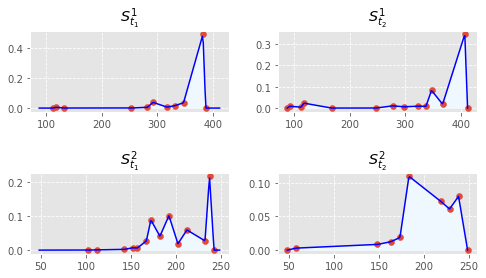

In [14]:
# fig, axs = plt.subplots(2, 2)

fig,axs = plt.subplots(2, 2,figsize = (8,4))
#fig = plt.figure(figsize = (10,10))


x11 = np.linspace(min(vv11), max(vv11), num=200, endpoint=True)
f11 = interp1d(vv11, pp11, kind='linear')
axs[0, 0].plot(x11,f11(x11),color="blue")
axs[0, 0].fill_between(x11,[0]*len(x11), f11(x11), color='aliceblue')
axs[0, 0].scatter(v11,f11(v11))
axs[0, 0].set_title(r'$S_{t_1}^1$')


x21 = np.linspace(min(vv21), max(vv21), num=200, endpoint=True)
f21 = interp1d(vv21, pp21, kind='linear')
axs[0, 1].plot(x21,f21(x21),color="blue")
axs[0, 1].fill_between(x11,[0]*len(x21), f21(x21), color='aliceblue')
axs[0, 1].scatter(v21,f21(v21))
axs[0, 1].set_title(r'$S_{t_2}^1$')


x12 = np.linspace(min(vv12), max(vv12), num=200, endpoint=True)
f12 = interp1d(vv12, pp12, kind='linear')
axs[1, 0].plot(x12,f12(x12),color="blue")
axs[1, 0].fill_between(x12,[0]*len(x12), f12(x12), color='aliceblue')
axs[1, 0].scatter(v12,f12(v12))
axs[1, 0].set_title(r'$S_{t_1}^2$')


x22 = np.linspace(min(vv22), max(vv22), num=200, endpoint=True)
f22 = interp1d(vv22, pp22, kind='linear')
axs[1, 1].plot(x22,f22(x22),color="blue")
axs[1, 1].fill_between(x22,[0]*len(x22), f22(x22), color='aliceblue')
axs[1, 1].scatter(v22,f22(v22))
axs[1, 1].set_title(r'$S_{t_2}^2$')

axs[0,0].grid(True, linestyle='--')
axs[0,1].grid(True, linestyle='--')
axs[1,0].grid(True, linestyle='--')
axs[1,1].grid(True, linestyle='--')
fig.subplots_adjust(right=0.9,top = 0.9,wspace = 0.25,hspace = 0.75)
plt.savefig('fig_marginal_densities.eps', format='eps')
plt.show()

U-Quantization

In [15]:
def discretize_density(density,min=0, max=10,N=10000,n=20,average=True,use_mean=False,mean_value=1):
    vv = np.linspace(min,max,N)
    epsilon = 1/n
    #Distribution Function:
    distr = np.cumsum(density(vv))/(np.cumsum(density(vv)))[-1]
    if average:
        v = np.zeros(n)
        for j in range(n-1):
            k=[]
            for i in range(N):
                if distr[i] >= ((j+1)/n - epsilon) and distr[i] < (j+1)/n :
                    k.append(vv[i])
            v[j] = np.mean(k)
        k=[]
        for i in range(N):
            if distr[i] >= (1-epsilon) and distr[i] < 1:
                k.append(vv[i])
        v[-1]=np.min(k)
        if use_mean:
            v[-1] = n*mean_value - np.sum(v[:n])
        p = np.repeat(1/n,n)
    else:
        v=np.linspace(min,max,n)
        p=density(v)
    return v,p

In [16]:
v11,p11 = discretize_density(interp1d(v11, p11, kind='linear'),min = min(v11),max = max(v11))
v12,p12 = discretize_density(interp1d(v12, p12, kind='linear'),min = min(v12),max = max(v12))
v21,p21 = discretize_density(interp1d(v21, p21, kind='linear'),min = min(v21),max = max(v21))
v22,p22 = discretize_density(interp1d(v22, p22, kind='linear'),min = min(v22),max = max(v22))
mean_11 = sum([v*p for v,p in zip(v11,p11)])
mean_21 = sum([v*p for v,p in zip(v21,p21)])
mean_12 = sum([v*p for v,p in zip(v12,p12)])
mean_22 = sum([v*p for v,p in zip(v22,p22)])
v11 = [v + 0.5*(mean_21-mean_11) for v in v11]
v21 = [v + 0.5*(mean_11-mean_21) for v in v21]
v12 = [v + 0.5*(mean_22-mean_12) for v in v12]
v22 = [v + 0.5*(mean_12-mean_22) for v in v22]

$\textbf{Compute Price Bounds given these Marginals}$

We first define the payoff functions

In [17]:
# We use the same payoff functions as always

def payoff1(a,b,c,d):
    return max((1/4)*(a+b+c+d)-250,0)

def payoff2(a,b,c,d):
    return max(250-min([a,b,c,d]),0)
    #return (c>a)*(d>b)

def payoff3(a,b,c,d):
    return (1/4)*max(b-a,0)*max(d-c,0)

def payoff4(a,b,c,d):
    return ((c-a)/a)**2*((d-b)/b)**2


First we compute the maximal possible values for the correlation

In [18]:
def extremal_correlation(v11,p11,v12,p12,v21,p21,v22,p22):
    v11 = np.array(v11)
    v12 = np.array(v12)
    v21 = np.array(v21)
    v22 = np.array(v22)
    p11 = np.array(p11)
    p12 = np.array(p12)
    p21 = np.array(p21)
    p22 = np.array(p22)    
    S_0_1 = np.sum(v11*p11)
    S_0_2 = np.sum(v12*p12)
    second_moment_1_t1 = np.sum(v11**2*p11)
    second_moment_2_t1 = np.sum(v12**2*p12)
    second_moment_1_t2 = np.sum(v21**2*p21)
    second_moment_2_t2 = np.sum(v22**2*p22)
    def correlation_payoff_time_1(a,b,c,d):
        return ((a*b-S_0_1*S_0_2)/(np.sqrt(second_moment_1_t1-S_0_1**2)*np.sqrt(second_moment_2_t1-S_0_2**2)))
        
    def correlation_payoff_time_2(a,b,c,d):
        return ((c*d-S_0_1*S_0_2)/(np.sqrt(second_moment_1_t2-S_0_1**2)*np.sqrt(second_moment_2_t2-S_0_2**2)))
         
    minimal_corr_time_1 = opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=correlation_payoff_time_1,onedim=True,minimize=True)[0]
    maximal_corr_time_1 = opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=correlation_payoff_time_1,onedim=True,minimize=False)[0] 
    minimal_corr_time_2 = opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=correlation_payoff_time_2,onedim=True,minimize=True)[0]
    maximal_corr_time_2 = opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=correlation_payoff_time_2,onedim=True,minimize=False)[0]     
    return minimal_corr_time_1, maximal_corr_time_1, minimal_corr_time_2, maximal_corr_time_2

In [19]:
minimal_corr_time_1,maximal_corr_time_1,minimal_corr_time_2,maximal_corr_time_2 = extremal_correlation(v11,p11,v12,p12,v21,p21,v22,p22)







print("The correlation at time 1 should be in between {c1} and {c2}".format(c1 = minimal_corr_time_1, c2 = maximal_corr_time_1))
print("The correlation at time 2 should be in between {c1} and {c2}".format(c1 = minimal_corr_time_2, c2 = maximal_corr_time_2))

Academic license - for non-commercial use only - expires 2022-10-07
Using license file C:\Users\julia\gurobi.lic
The correlation at time 1 should be in between -0.5869748346213925 and 0.7992554743509888
The correlation at time 2 should be in between -0.48706914373837407 and 0.8490985106113986


We compute the improvement through correlation information (at time 1)

In [20]:
### Correlation improvement

#Figure 1
# Nr. of Discretization Points
N = 20

lower_bound1 = []
upper_bound1 = []
lower_bound2 = []
upper_bound2 = []
lower_bound3 = []
upper_bound3 = []
lower_bound4 = []
upper_bound4 = []
corr = np.linspace(minimal_corr_time_1,maximal_corr_time_1,N)
lb1 = opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff1,onedim=True,minimize=True)[0]
ub1 = opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff1,onedim=True,minimize=False)[0]
lb2 = opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff2,onedim=True,minimize=True)[0]
ub2 = opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff2,onedim=True,minimize=False)[0]
lb3 = opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff3,onedim=True,minimize=True)[0]
ub3 = opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff3,onedim=True,minimize=False)[0]
lb4 = opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff4,onedim=True,minimize=True)[0]
ub4 = opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff4,onedim=True,minimize=False)[0]

for i in range(N):
    lower_bound1.append(opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,
                                                     func=payoff1,onedim=True,minimize=True,correlation_1=True,corr_1=corr[i])[0])
    upper_bound1.append(opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,
                                                     func=payoff1,onedim=True,minimize=False,correlation_1=True,corr_1=corr[i])[0])
    lower_bound2.append(opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,
                                                     func=payoff2,onedim=True,minimize=True,correlation_1=True,corr_1=corr[i])[0])
    upper_bound2.append(opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,
                                                     func=payoff2,onedim=True,minimize=False,correlation_1=True,corr_1=corr[i])[0])
    lower_bound3.append(opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,
                                                     func=payoff3,onedim=True,minimize=True,correlation_1=True,corr_1=corr[i])[0])
    upper_bound3.append(opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,
                                                     func=payoff3,onedim=True,minimize=False,correlation_1=True,corr_1=corr[i])[0])
    lower_bound4.append(opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,
                                                     func=payoff4,onedim=True,minimize=True,correlation_1=True,corr_1=corr[i])[0])
    upper_bound4.append(opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,
                                                     func=payoff4,onedim=True,minimize=False,correlation_1=True,corr_1=corr[i])[0])

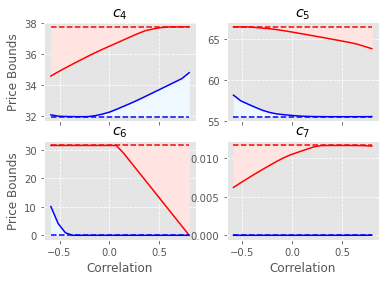

In [21]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(corr, lower_bound1,color="blue")
axs[0, 0].plot(corr, upper_bound1,color="red")
axs[0, 0].plot(corr, np.repeat(lb1,N), color="blue",linestyle = "--")
axs[0, 0].plot(corr, np.repeat(ub1,N),color="red",linestyle = "--")
axs[0, 0].set_title(r'$c_4$')
axs[0, 0].set_xticklabels([])
axs[0, 0].fill_between(corr, lower_bound1, np.repeat(lb1,N), color='aliceblue')
axs[0, 0].fill_between(corr, upper_bound1, np.repeat(ub1,N), color='mistyrose')
axs[0, 1].plot(corr, lower_bound2,color="blue")
axs[0, 1].plot(corr, upper_bound2,color="red")
axs[0, 1].plot(corr, np.repeat(lb2,N), color="blue",linestyle = "--")
axs[0, 1].plot(corr, np.repeat(ub2,N),color="red",linestyle = "--")
axs[0, 1].set_title(r'$c_5$')
axs[0, 1].set_xticklabels([])
axs[0, 1].fill_between(corr, lower_bound2, np.repeat(lb2,N), color='aliceblue')
axs[0, 1].fill_between(corr, upper_bound2, np.repeat(ub2,N), color='mistyrose')
axs[1, 0].plot(corr, lower_bound3,color="blue")
axs[1, 0].plot(corr, upper_bound3,color="red")
axs[1, 0].plot(corr, np.repeat(lb3,N), color="blue",linestyle = "--")
axs[1, 0].plot(corr, np.repeat(ub3,N),color="red",linestyle = "--")
axs[1, 0].set_title(r'$c_6$')
axs[1, 0].fill_between(corr, lower_bound3, np.repeat(lb3,N), color='aliceblue')
axs[1, 0].fill_between(corr, upper_bound3, np.repeat(ub3,N), color='mistyrose')
axs[1, 1].plot(corr, lower_bound4,color="blue")
axs[1, 1].plot(corr, upper_bound4,color="red")
axs[1, 1].plot(corr, np.repeat(lb4,N), color="blue",linestyle = "--")
axs[1, 1].plot(corr, np.repeat(ub4,N),color="red",linestyle = "--")
axs[1, 1].set_title(r'$c_7$')
axs[1, 1].fill_between(corr, lower_bound4, np.repeat(lb4,N), color='aliceblue')
axs[1, 1].fill_between(corr, upper_bound4, np.repeat(ub4,N), color='mistyrose')
axs[0, 0].set(ylabel='Price Bounds')
axs[1, 0].set(xlabel='Correlation', ylabel='Price Bounds')
axs[1, 1].set(xlabel='Correlation')
axs[0,0].grid(True, linestyle='--')
axs[0,1].grid(True, linestyle='--')
axs[1,0].grid(True, linestyle='--')
axs[1,1].grid(True, linestyle='--')
plt.savefig('fig_real_data_correlations_improvement_1.eps', format='eps')
plt.show()

Correlation information at time 2

In [22]:
### Correlation improvement

#Figure 1
# Nr. of Discretization Points
N = 20

lower_bound1 = []
upper_bound1 = []
lower_bound2 = []
upper_bound2 = []
lower_bound3 = []
upper_bound3 = []
lower_bound4 = []
upper_bound4 = []
corr = np.linspace(minimal_corr_time_2,maximal_corr_time_2,N)
lb1 = opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff1,onedim=True,minimize=True)[0]
ub1 = opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff1,onedim=True,minimize=False)[0]
lb2 = opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff2,onedim=True,minimize=True)[0]
ub2 = opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff2,onedim=True,minimize=False)[0]
lb3 = opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff3,onedim=True,minimize=True)[0]
ub3 = opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff3,onedim=True,minimize=False)[0]
lb4 = opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff4,onedim=True,minimize=True)[0]
ub4 = opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff4,onedim=True,minimize=False)[0]

for i in range(N):
    lower_bound1.append(opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,
                                                     func=payoff1,onedim=True,minimize=True,correlation_2=True,corr_2=corr[i])[0])
    upper_bound1.append(opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,
                                                     func=payoff1,onedim=True,minimize=False,correlation_2=True,corr_2=corr[i])[0])
    lower_bound2.append(opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,
                                                     func=payoff2,onedim=True,minimize=True,correlation_2=True,corr_2=corr[i])[0])
    upper_bound2.append(opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,
                                                     func=payoff2,onedim=True,minimize=False,correlation_2=True,corr_2=corr[i])[0])
    lower_bound3.append(opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,
                                                     func=payoff3,onedim=True,minimize=True,correlation_2=True,corr_2=corr[i])[0])
    upper_bound3.append(opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,
                                                     func=payoff3,onedim=True,minimize=False,correlation_2=True,corr_2=corr[i])[0])
    lower_bound4.append(opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,
                                                     func=payoff4,onedim=True,minimize=True,correlation_2=True,corr_2=corr[i])[0])
    upper_bound4.append(opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,
                                                     func=payoff4,onedim=True,minimize=False,correlation_2=True,corr_2=corr[i])[0])

Next, we plot this improvement

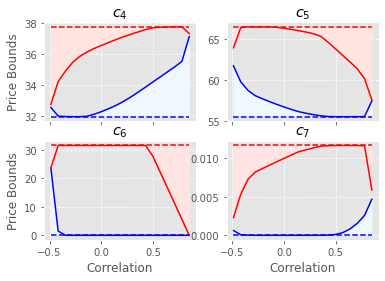

In [23]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(corr, lower_bound1,color="blue")
axs[0, 0].plot(corr, upper_bound1,color="red")
axs[0, 0].plot(corr, np.repeat(lb1,N), color="blue",linestyle = "--")
axs[0, 0].plot(corr, np.repeat(ub1,N),color="red",linestyle = "--")
axs[0, 0].set_title(r'$c_4$')
axs[0, 0].set_xticklabels([])
axs[0, 0].fill_between(corr, lower_bound1, np.repeat(lb1,N), color='aliceblue')
axs[0, 0].fill_between(corr, upper_bound1, np.repeat(ub1,N), color='mistyrose')
axs[0, 1].plot(corr, lower_bound2,color="blue")
axs[0, 1].plot(corr, upper_bound2,color="red")
axs[0, 1].plot(corr, np.repeat(lb2,N), color="blue",linestyle = "--")
axs[0, 1].plot(corr, np.repeat(ub2,N),color="red",linestyle = "--")
axs[0, 1].set_title(r'$c_5$')
axs[0, 1].set_xticklabels([])
axs[0, 1].fill_between(corr, lower_bound2, np.repeat(lb2,N), color='aliceblue')
axs[0, 1].fill_between(corr, upper_bound2, np.repeat(ub2,N), color='mistyrose')
axs[1, 0].plot(corr, lower_bound3,color="blue")
axs[1, 0].plot(corr, upper_bound3,color="red")
axs[1, 0].plot(corr, np.repeat(lb3,N), color="blue",linestyle = "--")
axs[1, 0].plot(corr, np.repeat(ub3,N),color="red",linestyle = "--")
axs[1, 0].set_title(r'$c_6$')
axs[1, 0].fill_between(corr, lower_bound3, np.repeat(lb3,N), color='aliceblue')
axs[1, 0].fill_between(corr, upper_bound3, np.repeat(ub3,N), color='mistyrose')
axs[1, 1].plot(corr, lower_bound4,color="blue")
axs[1, 1].plot(corr, upper_bound4,color="red")
axs[1, 1].plot(corr, np.repeat(lb4,N), color="blue",linestyle = "--")
axs[1, 1].plot(corr, np.repeat(ub4,N),color="red",linestyle = "--")
axs[1, 1].set_title(r'$c_7$')
axs[1, 1].fill_between(corr, lower_bound4, np.repeat(lb4,N), color='aliceblue')
axs[1, 1].fill_between(corr, upper_bound4, np.repeat(ub4,N), color='mistyrose')
axs[0, 0].set(ylabel='Price Bounds')
axs[1, 0].set(xlabel='Correlation', ylabel='Price Bounds')
axs[1, 1].set(xlabel='Correlation')
axs[0,0].grid(True, linestyle='--')
axs[0,1].grid(True, linestyle='--')
axs[1,0].grid(True, linestyle='--')
axs[1,1].grid(True, linestyle='--')
plt.savefig('fig_real_data_correlations_improvement_2.eps', format='eps')
plt.show()

# Additional Assumptions

Finally we include $\textbf{additional assumptions}$

First, we estimate the historical correlation

In [24]:
company_1_time_series = pd.read_csv('csv/company_1_time_series.csv')
company_2_time_series = pd.read_csv('csv/company_2_time_series.csv')

We first plot the time series

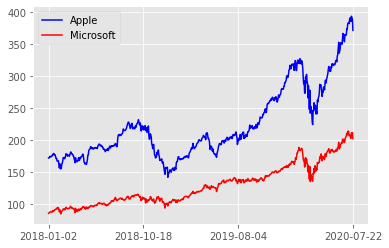

In [25]:
start = dt.date(2018, 1, 2)
x_range = [0,200,400,644]
x_ticks = [start + dt.timedelta(days = np.floor(i*365/252)) for i in x_range]
plt.plot(company_1_time_series,'b-',label = "Apple")
plt.plot(company_2_time_series,'r-',label = "Microsoft")
plt.legend(loc="upper left")
plt.xticks(x_range,x_ticks)
plt.show()

Normalized Values

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


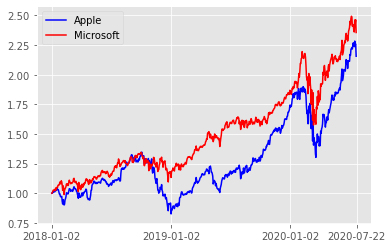

In [26]:
start = dt.date(2018, 1, 2)
x_range = [0,252,504,644]
x_ticks = [start + dt.timedelta(days = np.floor(i*365/252)) for i in x_range]
plt.plot(company_1_time_series/company_1_time_series.CLOSE[0],'b-',label = "Apple")
plt.plot(company_2_time_series/company_2_time_series.CLOSE[0],'r-',label = "Microsoft")
plt.legend(loc="upper left")
plt.xticks(x_range,x_ticks)
plt.savefig('correlation_apple_microsoft.eps', format='eps')
plt.show()

# Bootstrapping-Approach

Distribution of the daily returns 
$
\frac{S_{t_{i+1}}-S_{t_i}}{S_{t_i}}
$

<ipython-input-27-ce9f5351a030>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


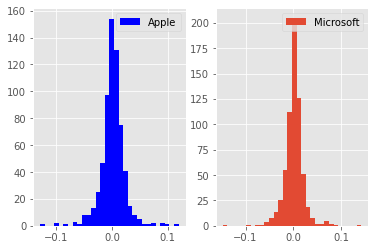

In [27]:
returns_1 = np.diff(company_1_time_series['CLOSE'])/company_1_time_series['CLOSE'][:-1]
returns_2 = np.diff(company_2_time_series['CLOSE'])/company_2_time_series['CLOSE'][:-1]
fig, ax = plt.subplots(1,2)
ax[0].hist(returns_1,label = "Apple",bins = 30,color ="blue")
ax[0].legend()
ax[1].hist(returns_2,label = "Microsoft",bins = 30)
ax[1].legend()
fig.show()


In [28]:
N = 100000 # Number of Simulations for Bootstrapping
S_01 = company_1_time_series['CLOSE'][len(company_1_time_series['CLOSE'])-1]
S_02 = company_2_time_series['CLOSE'][len(company_2_time_series['CLOSE'])-1]
t1 = 11
t2 = 32
results_t1_asset_1 = []
results_t1_asset_2 = []
results_t2_asset_1 = []
results_t2_asset_2 = []
for i in range(N):
    path1 = np.zeros(t2)
    path1[0] =  S_01
    path2 = np.zeros(t2)
    path2[0] =  S_02
    for j in range(1,t2):
        random_index = random.choice([i for i in range(len(returns_1))])
        path1[j] = path1[j-1]+returns_1[random_index]*path1[j-1]
        path2[j] = path2[j-1]+returns_2[random_index]*path2[j-1]
    results_t1_asset_1.append(path1[t1-1])
    results_t1_asset_2.append(path2[t1-1])
    results_t2_asset_1.append(path1[t2-1])
    results_t2_asset_2.append(path2[t2-1])

Estimation of Correlation

In [29]:
corr_p_t1, p_value_t1 = pearsonr(results_t1_asset_1, results_t1_asset_2)
corr_p_t2, p_value_t2 = pearsonr(results_t2_asset_1, results_t2_asset_2)
print("Estimated Correlation at time 1: {}".format(corr_p_t1))
print("Estimated Correlation at time 2: {}".format(corr_p_t2))

Estimated Correlation at time 1: 0.7956197707820005
Estimated Correlation at time 2: 0.7952647051839692


Confidence Interval (Steiger's Z-Test)

In [30]:
alpha = 0.01

def pearsonr_ci(x,y,alpha=0.01):
    r, p = stats.pearsonr(x,y) 
    r_z = np.arctanh(r) # Fisher-Transformation
    se = 1/np.sqrt(len(x)-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

_,_,low,high = pearsonr_ci(results_t1_asset_1, results_t1_asset_2,alpha)
print("{p}% Confidence Interval at time t1: [{l},{h}]".format(p = 100*(1-alpha), l = low,h = high))
_,_,low,high = pearsonr_ci(results_t2_asset_1, results_t2_asset_2,alpha)
print("{p}% Confidence Interval at time t2: [{l},{h}]".format(p = 100*(1-alpha), l = low,h = high))



99.0% Confidence Interval at time t1: [0.7926109873709555,0.7985898074644255]
99.0% Confidence Interval at time t2: [0.7922512994370697,0.7982393218832157]


We compute the price bounds under additional assumptions

# Bounds without Assumptions

In [33]:
## First Row of Table
m12 = (opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff1,onedim=True,minimize=True)[0])
m13 = (opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff1,onedim=True,minimize=False)[0])
m12=round(m12,4)
m13=round(m13,4)
table_text = "No additional assumptions  \n ------------ \n" + "{m12:.4f} | {m13:.4f}\n"

## Next Row of Table
m22 = (opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff2,onedim=True,minimize=True)[0])
m23 = (opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff2,onedim=True,minimize=False)[0])
m22=round(m22,4)
m23=round(m23,4)
table_text = table_text+"{m22:.4f} | {m23:.4f} \n"

## Next Row of Table
m32 = (opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff3,onedim=True,minimize=True)[0])
m33 = (opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff3,onedim=True,minimize=False)[0])
m32=round(m32,4)
m33=round(m33,4)
table_text = table_text+"{m32:.4f} | {m33:.4f}  \n"

## Next Row of Table
m42 = (opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff4,onedim=True,minimize=True)[0])
m43 = (opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff4,onedim=True,minimize=False)[0])
m42=round(m42,4)
m43=round(m43,4)
table_text = table_text+"{m42:.4f} | {m43:.4f} \n"

print(table_text.format(m12 =m12,m13=m13,m22=m22,m23=m23,m32=m32,m33=m33,m42=m42,m43=m43))

No additional assumptions  
 ------------ 
31.9339 | 37.7576
55.5357 | 66.5152 
0.0000 | 31.6319  
0.0000 | 0.0116 



### 1) Constant correlation

In [34]:
## First Row of Table
m12 = (opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff1,onedim=True,minimize=True,same_correlation = True)[0])
m13 = (opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff1,onedim=True,minimize=False,same_correlation = True)[0])
m12=round(m12,4)
m13=round(m13,4)
table_text = "Constant Correlation \n ------------ \n" + "{m12:.4f} | {m13:.4f}  \n"

## First Row of Table
m22 = (opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff2,onedim=True,minimize=True,same_correlation = True)[0])
m23 = (opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff2,onedim=True,minimize=False,same_correlation = True)[0])
m22=round(m22,4)
m23=round(m23,4)
table_text = table_text+"{m22:.4f} | {m23:.4f} \n"

## First Row of Table
m32 = (opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff3,onedim=True,minimize=True,same_correlation = True)[0])
m33 = (opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff3,onedim=True,minimize=False,same_correlation = True)[0])
m32=round(m32,4)
m33=round(m33,4)
table_text = table_text+"{m32:.4f} | {m33:.4f} \n"

## First Row of Table
m42 = (opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff4,onedim=True,minimize=True,same_correlation = True)[0])
m43 = (opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff4,onedim=True,minimize=False,same_correlation = True)[0])
m42=round(m42,4)
m43=round(m43,4)
table_text = table_text+"{m42:.4f} | {m43:.4f} \n"

print(table_text.format(m12 =m12,m13=m13,m22=m22,m23=m23,m32=m32,m33=m33,m42=m42,m43=m43))

Constant Correlation 
 ------------ 
31.9344 | 37.7576  
55.5357 | 66.3507 
0.0000 | 31.6319 
0.0000 | 0.0116 



### 2) Constant correlation, lower bounded 0.75

In [36]:
corr_p=0.75
## First Row of Table
m12 = (opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff1,onedim=True,minimize=True,same_correlation = True,q_corr_greater_p_const= corr_p,q_corr_greater_p = True)[0])
m13 = (opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff1,onedim=True,minimize=False,same_correlation = True,q_corr_greater_p_const= corr_p,q_corr_greater_p = True)[0])
m12=round(m12,4)
m13=round(m13,4)
table_text = "Constant Correlation, lower bounded \n ------------ \n" + "{m12:.4f} | {m13:.4f}  \n"

## First Row of Table
m22 = (opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff2,onedim=True,minimize=True,same_correlation = True,q_corr_greater_p_const= corr_p,q_corr_greater_p = True)[0])
m23 = (opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff2,onedim=True,minimize=False,same_correlation = True,q_corr_greater_p_const= corr_p,q_corr_greater_p = True)[0])
m22=round(m22,4)
m23=round(m23,4)
table_text = table_text+"{m22:.4f} | {m23:.4f}\n"

## First Row of Table
m32 = (opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff3,onedim=True,minimize=True,same_correlation = True,q_corr_greater_p_const= corr_p,q_corr_greater_p = True)[0])
m33 = (opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff3,onedim=True,minimize=False,same_correlation = True,q_corr_greater_p_const= corr_p,q_corr_greater_p = True)[0])
m32=round(m32,4)
m33=round(m33,4)
table_text = table_text+"{m32:.4f} | {m33:.4f}\n"

## First Row of Table
m42 = (opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff4,onedim=True,minimize=True,same_correlation = True,q_corr_greater_p_const= corr_p,q_corr_greater_p = True)[0])
m43 = (opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff4,onedim=True,minimize=False,same_correlation = True,q_corr_greater_p_const= corr_p,q_corr_greater_p = True)[0])
m42=round(m42,4)
m43=round(m43,4)
table_text = table_text+"{m42:.4f} | {m43:.4f}\n"


print(table_text.format(m12 =m12,m13=m13,m22=m22,m23=m23,m32=m32,m33=m33,m42=m42,m43=m43))

Constant Correlation, lower bounded 
 ------------ 
35.3573 | 37.7576  
55.5398 | 60.6242
0.0000 | 2.1662
0.0023 | 0.0116



### 3) Only lower bounded with 0.75 but no constant correlation

In [37]:
corr_p=0.75
## First Row of Table
m12 = (opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff1,onedim=True,minimize=True,q_corr_greater_p_const= corr_p,q_corr_greater_p = True)[0])
m13 = (opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff1,onedim=True,minimize=False,q_corr_greater_p_const= corr_p,q_corr_greater_p = True)[0])
m12=round(m12,4)
m13=round(m13,4)
table_text = "Correlation lower bounded \n ------------ \n" + "{m12:.4f} | {m13:.4f}  \n"

## First Row of Table
m22 = (opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff2,onedim=True,minimize=True,q_corr_greater_p_const= corr_p,q_corr_greater_p = True)[0])
m23 = (opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff2,onedim=True,minimize=False,q_corr_greater_p_const= corr_p,q_corr_greater_p = True)[0])
m22=round(m22,4)
m23=round(m23,4)
table_text = table_text+"{m22:.4f} | {m23:.4f} \n"

## First Row of Table
m32 = (opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff3,onedim=True,minimize=True,q_corr_greater_p_const= corr_p,q_corr_greater_p = True)[0])
m33 = (opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff3,onedim=True,minimize=False,q_corr_greater_p_const= corr_p,q_corr_greater_p = True)[0])
m32=round(m32,4)
m33=round(m33,4)
table_text = table_text+"{m32:.4f} | {m33:.4f} \n"

## First Row of Table
m42 = (opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff4,onedim=True,minimize=True,q_corr_greater_p_const= corr_p,q_corr_greater_p = True)[0])
m43 = (opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff4,onedim=True,minimize=False,q_corr_greater_p_const= corr_p,q_corr_greater_p = True)[0])
m42=round(m42,4)
m43=round(m43,4)
table_text = table_text+"{m42:.4f} | {m43:.4f}  \n"


print(table_text.format(m12 =m12,m13=m13,m22=m22,m23=m23,m32=m32,m33=m33,m42=m42,m43=m43))

Correlation lower bounded 
 ------------ 
34.4798 | 37.7576  
55.5359 | 64.0369 
0.0000 | 2.1662 
0.0000 | 0.0116  



### 4) Constant correlation, lower bounded 0.79

In [38]:
corr_p=0.79
## First Row of Table
m12 = (opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff1,onedim=True,minimize=True,same_correlation = True,q_corr_greater_p_const= corr_p,q_corr_greater_p = True)[0])
m13 = (opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff1,onedim=True,minimize=False,same_correlation = True,q_corr_greater_p_const= corr_p,q_corr_greater_p = True)[0])
m12=round(m12,4)
m13=round(m13,4)
table_text = "Constant Correlation, lower bounded \n ------------ \n" + "{m12:.4f} | {m13:.4f}  \n"

## First Row of Table
m22 = (opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff2,onedim=True,minimize=True,same_correlation = True,q_corr_greater_p_const= corr_p,q_corr_greater_p = True)[0])
m23 = (opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff2,onedim=True,minimize=False,same_correlation = True,q_corr_greater_p_const= corr_p,q_corr_greater_p = True)[0])
m22=round(m22,4)
m23=round(m23,4)
table_text = table_text+"{m22:.4f} | {m23:.4f}\n"

## First Row of Table
m32 = (opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff3,onedim=True,minimize=True,same_correlation = True,q_corr_greater_p_const= corr_p,q_corr_greater_p = True)[0])
m33 = (opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff3,onedim=True,minimize=False,same_correlation = True,q_corr_greater_p_const= corr_p,q_corr_greater_p = True)[0])
m32=round(m32,4)
m33=round(m33,4)
table_text = table_text+"{m32:.4f} | {m33:.4f}\n"

## First Row of Table
m42 = (opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff4,onedim=True,minimize=True,same_correlation = True,q_corr_greater_p_const= corr_p,q_corr_greater_p = True)[0])
m43 = (opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff4,onedim=True,minimize=False,same_correlation = True,q_corr_greater_p_const= corr_p,q_corr_greater_p = True)[0])
m42=round(m42,4)
m43=round(m43,4)
table_text = table_text+"{m42:.4f} | {m43:.4f}\n"


print(table_text.format(m12 =m12,m13=m13,m22=m22,m23=m23,m32=m32,m33=m33,m42=m42,m43=m43))

Constant Correlation, lower bounded 
 ------------ 
35.6111 | 37.7576  
55.5802 | 59.9411
0.0000 | 0.4070
0.0028 | 0.0116



### 5) Only lower bounded with 0.79 but no constant correlation

In [39]:
corr_p=0.79
## First Row of Table
m12 = (opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff1,onedim=True,minimize=True,same_correlation = True,q_corr_greater_p_const= corr_p,q_corr_greater_p = True)[0])
m13 = (opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff1,onedim=True,minimize=False,same_correlation = True,q_corr_greater_p_const= corr_p,q_corr_greater_p = True)[0])
m12=round(m12,4)
m13=round(m13,4)
table_text = "Constant Correlation, lower bounded \n ------------ \n" + "{m12:.4f} | {m13:.4f}  \n"

## First Row of Table
m22 = (opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff2,onedim=True,minimize=True,same_correlation = True,q_corr_greater_p_const= corr_p,q_corr_greater_p = True)[0])
m23 = (opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff2,onedim=True,minimize=False,same_correlation = True,q_corr_greater_p_const= corr_p,q_corr_greater_p = True)[0])
m22=round(m22,4)
m23=round(m23,4)
table_text = table_text+"{m22:.4f} | {m23:.4f}\n"

## First Row of Table
m32 = (opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff3,onedim=True,minimize=True,same_correlation = True,q_corr_greater_p_const= corr_p,q_corr_greater_p = True)[0])
m33 = (opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff3,onedim=True,minimize=False,same_correlation = True,q_corr_greater_p_const= corr_p,q_corr_greater_p = True)[0])
m32=round(m32,4)
m33=round(m33,4)
table_text = table_text+"{m32:.4f} | {m33:.4f}\n"

## First Row of Table
m42 = (opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff4,onedim=True,minimize=True,same_correlation = True,q_corr_greater_p_const= corr_p,q_corr_greater_p = True)[0])
m43 = (opt_plan_discrete_multiasset(v11,p11,v12,p12,v21,p21,v22,p22,func=payoff4,onedim=True,minimize=False,same_correlation = True,q_corr_greater_p_const= corr_p,q_corr_greater_p = True)[0])
m42=round(m42,4)
m43=round(m43,4)
table_text = table_text+"{m42:.4f} | {m43:.4f}\n"


print(table_text.format(m12 =m12,m13=m13,m22=m22,m23=m23,m32=m32,m33=m33,m42=m42,m43=m43))

Constant Correlation, lower bounded 
 ------------ 
35.6111 | 37.7576  
55.5802 | 59.9411
0.0000 | 0.4070
0.0028 | 0.0116

